In [1]:
import numpy as np
from scipy.interpolate import interp1d
import qnm_filter
import sys
import qnm
import random
import argparse
import scipy.linalg as sl
import matplotlib.pyplot as pl
from scipy.special import logsumexp
from pathlib import Path
import glob

In [2]:
def signal_creator():
    global signal, signal220, signal330, t_range
    injected = (100, 0.5)
    mass = qnm_filter.Filter.mass_unit(injected[0])
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    omega330 = qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=injected[1])[0]

    mmax = 8.4 * 1e-21
    phase1 = 0
    A220x = mmax*np.cos(phase1)
    A220y = mmax*np.sin(phase1)
    phase2 = 0
    A330x = mmax*np.cos(phase2)
    A330y = mmax*np.sin(phase2)

    amp220 = 1
    amp330 = 1

    sampling_frequency = 4096 * 1  # in Hz
    duration = 4  # in second
    t_range = np.arange(-duration / 2, duration / 2, 1 / sampling_frequency)
    signal220 = np.real(amp220 * (A220x + 1j * A220y) * np.exp(-1j * omega220 * np.abs(t_range / mass)))
    signal330 = np.real(amp330 * (A330x + 1j * A330y) * np.exp(-1j * omega330 * np.abs(t_range / mass)))
    signal = signal220+signal330

## 220

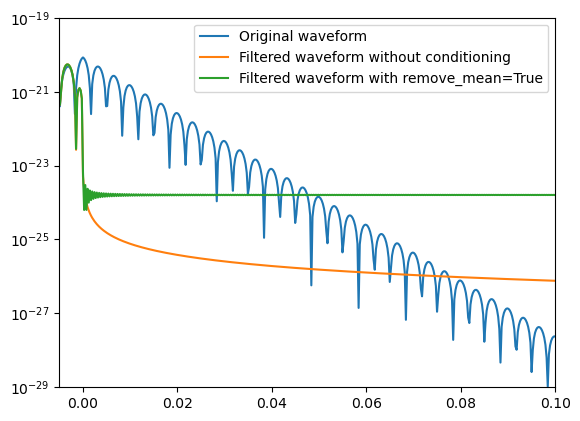

In [4]:
signal_creator()
fit = qnm_filter.Network(segment_length=0.2, srate=4096 * 1, t_init=0.0)
fit.original_data['H1'] = qnm_filter.RealData(signal220, index=t_range)
fit.detector_alignment()
fit.add_filter(mass=100, chi=0.5, model_list=[(2,2,0,'p')])

pl.semilogy(abs(fit.original_data['H1']), label='Original waveform')
pl.semilogy(abs(fit.filtered_data['H1']), label='Filtered waveform without conditioning')
pl.xlim(-0.005, 0.1)
pl.ylim(1e-29, 1e-19)

fit.condition_data('original_data', remove_mean=True)
fit.add_filter(mass=100, chi=0.5, model_list=[(2,2,0,'p')])
pl.semilogy(abs(fit.filtered_data['H1']), label='Filtered waveform with remove_mean=True')
pl.legend()

# fit = qnm_filter.Network(segment_length=0.2, srate=4096 * 1, t_init=0.0)
# fit.original_data['H1'] = qnm_filter.RealData(signal220, index=t_range)
# fit.detector_alignment()
# fit.condition_data('original_data', remove_mean=True)
# fit.add_filter(mass=100, chi=0.5, model_list=[(2,2,0,'p')])
# pl.semilogy(abs(fit.filtered_data['H1']), )

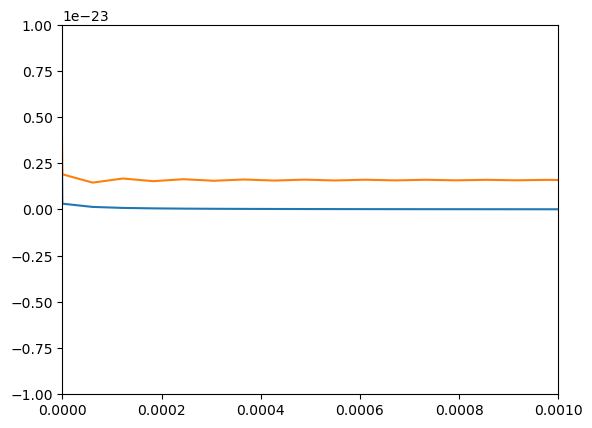

In [24]:
signal_creator()
fit = qnm_filter.Network(segment_length=0.2, srate=4096 * 4, t_init=0.0)
fit.original_data['H1'] = qnm_filter.RealData(signal220, index=t_range)
fit.detector_alignment()
fit.add_filter(mass=100, chi=0.5, model_list=[(2,2,0,'p')])

pl.plot(abs(fit.filtered_data['H1']))
pl.xlim(-0.0, 0.001)
pl.ylim(-1e-23, 1e-23)

fit.condition_data('original_data', remove_mean=True)
fit.add_filter(mass=100, chi=0.5, model_list=[(2,2,0,'p')])
pl.plot(abs(fit.filtered_data['H1']))

## 220+221

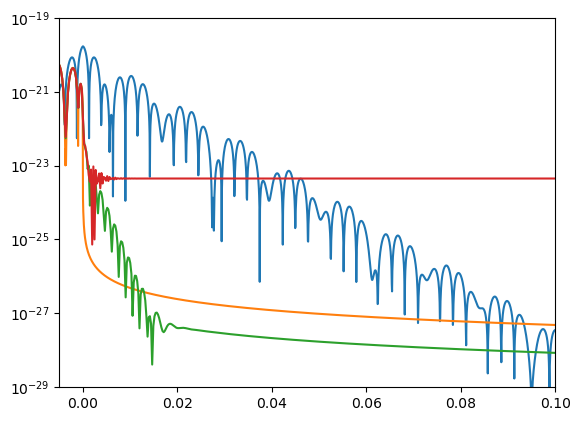

In [34]:
signal_creator()
fit = qnm_filter.Network(segment_length=0.2, srate=4096 * 1, t_init=0.0)
fit.original_data['H1'] = qnm_filter.RealData(signal220+signal330, index=t_range)
fit.detector_alignment()
fit.add_filter(mass=100, chi=0.5, model_list=[(2,2,0,'p'), (3,3,0,'p')])

pl.semilogy(abs(fit.original_data['H1']))
pl.semilogy(abs(fit.filtered_data['H1']))
pl.xlim(-0.005, 0.1)
pl.ylim(1e-29, 1e-19)

fit.condition_data('original_data', remove_mean=False)
fit.add_filter(mass=100, chi=0.5, model_list=[(2,2,0,'p'), (3,3,0,'p')])
pl.semilogy(abs(fit.filtered_data['H1']))

fit.condition_data('original_data', remove_mean=True)
fit.add_filter(mass=100, chi=0.5, model_list=[(2,2,0,'p'), (3,3,0,'p')])
pl.semilogy(abs(fit.filtered_data['H1']))


## No filter

In [28]:
mmax = 8.4 * 1e-21
acf_scale = 5e-1*8/6
signal_creator()
fit = qnm_filter.Network(segment_length=0.2, srate=4096 * 1, t_init=0.0)
fit.original_data['H1'] = qnm_filter.RealData(signal220+signal330, index=t_range)
fit.detector_alignment()
fit.condition_data('original_data')
fit.compute_acfs('original_data')
temp_acf = np.full(len(fit.acfs['H1']), 0, dtype = np.double)
temp_acf[0] = (mmax)**2*acf_scale**2
fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
fit.cholesky_decomposition()
fit.first_index()

fit.original_data['H1'] = qnm_filter.RealData(signal220, index=t_range)
fit.condition_data('original_data')
template = fit.truncate_data(fit.original_data)['H1']
SNR220 = fit.compute_SNR(None, template, 'H1', optimal=True)

fit.original_data['H1'] = qnm_filter.RealData(signal221, index=t_range)
fit.condition_data('original_data')
template = fit.truncate_data(fit.original_data)['H1']
SNR221 = fit.compute_SNR(None, template, 'H1', optimal=True)

fit.original_data['H1'] = qnm_filter.RealData(signal220+signal221, index=t_range)
fit.condition_data('original_data')
template = fit.truncate_data(fit.original_data)['H1']
SNRtot = fit.compute_SNR(None, template, 'H1', optimal=True)
print(SNRtot)

6.140923492264968


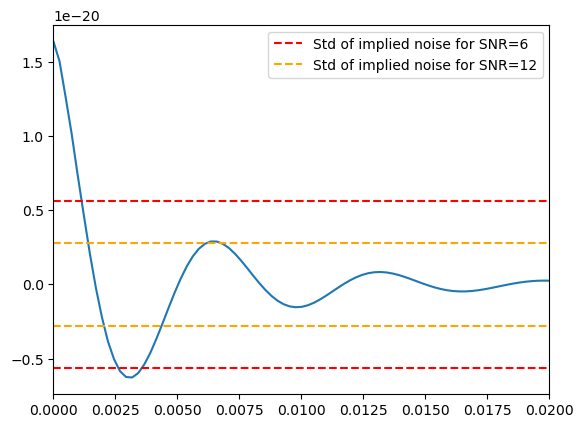

In [29]:
pl.plot(fit.original_data['H1'])
acf_scale = 5e-1*8/6
pl.axhline(mmax*acf_scale, color='r', ls='--', label='Std of implied noise for SNR=6')
pl.axhline(-mmax*acf_scale, color='r', ls='--')
acf_scale = 5e-1/1.5
pl.axhline(mmax*acf_scale, color='orange', ls='--', label='Std of implied noise for SNR=12')
pl.axhline(-mmax*acf_scale, color='orange', ls='--')
pl.xlim(0, 0.02)
pl.legend()